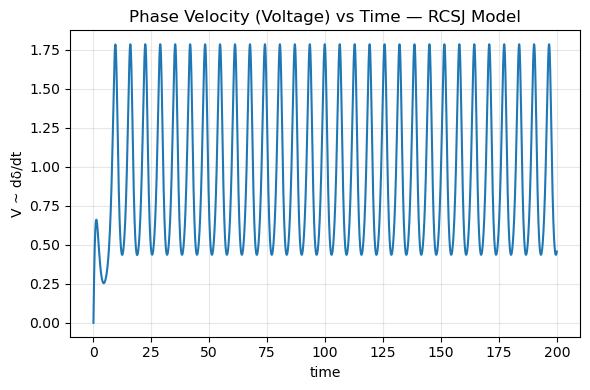

In [32]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

plt.rcParams['font.family'] = ['DejaVu Sans', 'Malgun Gothic']
plt.rcParams['axes.unicode_minus'] = False

# -----------------------------
# RCSJ 모델 정의
# -----------------------------
Ic, R, C = 1.0, 1.0, 1.0
Q = R * np.sqrt(C / Ic)   # 감쇠 인자

def rcsj(t, y, Ib):
    """단일 Josephson Junction의 RCSJ 방정식"""
    δ, dδ = y
    ddδ = Ib - np.sin(δ) - dδ/Q 
    return [dδ, ddδ]

# -----------------------------
# 시간에 따른 Phase Velocity 시뮬레이션
# -----------------------------
t_span = (0, 200)
t_eval = np.linspace(*t_span, 4000)
Ib = 1.2
sol = solve_ivp(rcsj, t_span, [0, 0], args=(Ib,), t_eval=t_eval)
V = sol.y[1]

plt.figure(figsize=(6,4))
plt.plot(sol.t, V)
plt.xlabel('time')
plt.ylabel('V ~ dδ/dt')
plt.title('Phase Velocity (Voltage) vs Time — RCSJ Model')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

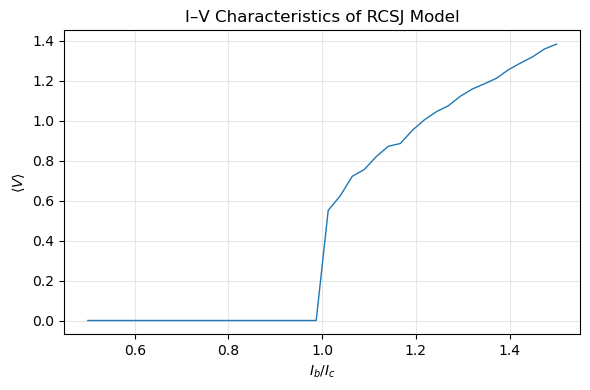

In [36]:
currents = np.linspace(0.5, 1.5, 40)
avg_V = []
avg_window = 0.8 # 평균 낼 때 마지막 20% 구간만 사용

for Ib in currents:
    sol = solve_ivp(rcsj, (0, 500), [0, 0], args=(Ib,), t_eval=np.linspace(0, 500, 3000))
    V = sol.y[1]
    avg_V.append(np.mean(V[int(len(V)*avg_window):])) 

plt.figure(figsize=(6,4))
plt.plot(currents, avg_V, '-', lw=1)
plt.xlabel('$I_b / I_c$')
plt.ylabel('$⟨V⟩$')
plt.title('I–V Characteristics of RCSJ Model')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


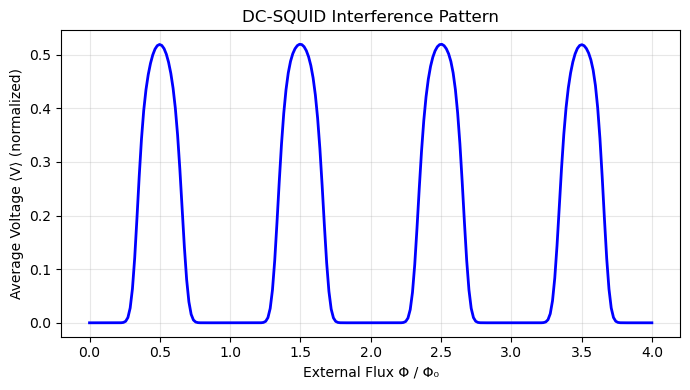

In [ ]:
# -----------------------------
# DC-SQUID 모델 정의 및 시뮬레이션
# -----------------------------
Phi0 = 1.0                # 플럭스 양자
alpha_couple = 2.0        # 두 접합 간의 결합 상수
Ib_squid = 1.1            # SQUID의 바이어스 전류 (normalized)
Q_squid = 6.0             # 감쇠 인자


def squid(t, y, phi_ext):
    δ1, v1, δ2, v2 = y
    coupling = (δ2 - δ1 - 2*np.pi*phi_ext/Phi0)  # 외부 플럭스에 의한 위상 결합항
    dd1 = rcsj(t, [δ1, v1], Ib_squid/2 + alpha_couple*coupling)[1]
    dd2 = rcsj(t, [δ2, v2], Ib_squid/2 - alpha_couple*coupling)[1]
    return [v1, dd1, v2, dd2]  

# -----------------------------
# 외부 플럭스에 따른 전압 평균
# -----------------------------
phi_ext_values = np.linspace(0, 4, 250)
Vavg_squid = []

t_span = (0, 300)              
t_eval = np.linspace(*t_span, 1000) 

# 각 Φ_ext에 대한 SQUID 응답 시뮬레이션
for phi_ext in phi_ext_values:
    sol = solve_ivp(squid, t_span, [0,0,0,0],
                    args=(phi_ext,), method='RK45',
                    t_eval=t_eval, rtol=1e-5, atol=1e-7)
    V = (sol.y[1] + sol.y[3]) / 2        # 두 접합의 평균 전압 (V ~ δ_dot)
    Vavg_squid.append(np.mean(V[int(len(V)*avg_window):]))  # 수렴 후 평균 전압

# -----------------------------
# 결과 처리 및 시각화
# -----------------------------
Vavg_squid = np.array(Vavg_squid)
Vavg_smooth = gaussian_filter1d(Vavg_squid, sigma=2)  # 가우시안 필터로 평활화

plt.figure(figsize=(7,4))
plt.plot(phi_ext_values, Vavg_smooth, 'b-', lw=2)
plt.xlabel('External Flux Φ / Φ₀')
plt.ylabel('Average Voltage ⟨V⟩ (normalized)')
plt.title('DC-SQUID Interference Pattern')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

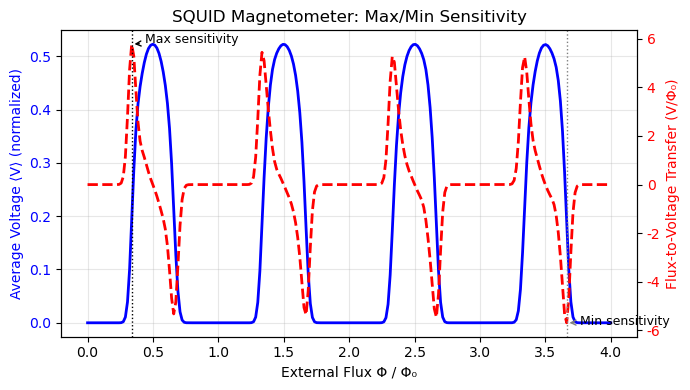

In [41]:
# 감도 계산
Vavg_array = np.array(Vavg_squid)
Vavg_smooth = gaussian_filter1d(Vavg_array, sigma=1.5)
dV_dPhi = np.gradient(Vavg_smooth, phi_ext_values)
abs_dV = np.abs(dV_dPhi)

# 최대/최소 감도 지점
imax = np.argmax(dV_dPhi)   # 가장 양의 방향으로 급한 변화 (최대 감도)
imin = np.argmin(dV_dPhi)   # 가장 음의 방향으로 급한 변화 (최소 감도)

phi_max = phi_ext_values[imax]
phi_min = phi_ext_values[imin]
Vphi_max = dV_dPhi[imax]
Vphi_min = dV_dPhi[imin]

# 시각화
fig, ax1 = plt.subplots(figsize=(7,4))

ax1.plot(phi_ext_values, Vavg_smooth, 'b-', lw=2, label='⟨V⟩(Φ)')
ax1.set_xlabel('External Flux Φ / Φ₀')
ax1.set_ylabel('Average Voltage ⟨V⟩ (normalized)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(phi_ext_values, dV_dPhi, 'r--', lw=2, label='d⟨V⟩/dΦ')
ax2.set_ylabel('Flux-to-Voltage Transfer (V/Φ₀)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 감도 최대/최소 표시
ax2.axvline(phi_max, color='k', ls=':', lw=1)
ax2.axvline(phi_min, color='gray', ls=':', lw=1)

ax2.annotate('Max sensitivity',
             xy=(phi_max, Vphi_max),
             xytext=(phi_max+0.1, Vphi_max+0.05),
             arrowprops=dict(arrowstyle='->', color='k'),
             fontsize=9)

ax2.annotate('Min sensitivity',
             xy=(phi_min, Vphi_min),
             xytext=(phi_min+0.1, Vphi_min-0.1),
             arrowprops=dict(arrowstyle='->', color='gray'),
             fontsize=9)

plt.title('SQUID Magnetometer: Max/Min Sensitivity')
fig.tight_layout()
plt.show()